Question Paper link:https://docs.google.com/document/d/1nJdxx1ojyT3KKZTB3xRYtxOVCEDVCHSOFLYpQlP5mbg/edit?tab=t.0

Task 1

In [ ]:
import pandas as pd
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score


df = pd.read_csv("IMDB Dataset.csv")

#  Preprocessing function
def preprocess_text(text):
    text = text.lower()  # lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df["clean_review"] = df["review"].apply(preprocess_text)

# Split first, using the cleaned text column
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["clean_review"], df["sentiment"],
    test_size=0.3,
    stratify=df["sentiment"],
    random_state=42
)

# Initialize TF-IDF
vectorizer = TfidfVectorizer(tokenizer=str.split)

# Fit ONLY on training text
X_train = vectorizer.fit_transform(X_train_text)

# Transform test text using the same fitted vectorizer
X_test = vectorizer.transform(X_test_text)


# Train Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


# Predictions & Evaluation

y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred, average="weighted")
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Weighted F1 Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Weighted F1 Score: 0.8960596777193967

Confusion Matrix:
 [[6659  841]
 [ 718 6782]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.89      0.90      7500
    positive       0.89      0.90      0.90      7500

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



Task 2

In [ ]:
import os
import kagglehub
import numpy as np


path = kagglehub.dataset_download("danielwillgeorge/glove6b100dtxt")
glove_file = os.path.join(path, "glove.6B.100d.txt")

def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

embeddings = load_glove_embeddings(glove_file)
print("Loaded words:", len(embeddings))



# Vector arithmetic: Queen - Woman + Man
def find_closest_word(vec, embeddings, exclude=[]):
    best_word, best_sim = None, -9999999999999999999999999999
    for word, emb in embeddings.items():
        if word in exclude:
            continue
        sim = np.dot(vec, emb) / (np.linalg.norm(vec) * np.linalg.norm(emb))  # cosine similarity
        if sim > best_sim:
            best_word, best_sim = word, sim
    return best_word, best_sim

queen = embeddings['queen']
woman = embeddings['woman']
man   = embeddings['man']

target_vec = queen - woman + man
closest_word, similarity = find_closest_word(target_vec, embeddings, exclude=['queen','woman','man'])

print("Analogy Result: Queen - Woman + Man ≈", closest_word)
print("Cosine similarity:", similarity)


Loaded words: 400000
Analogy Result: Queen - Woman + Man ≈ king
Cosine similarity: 0.7940503


Task 3

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


CBOW similarity (money vs bank): 0.49015608
Skipgram similarity (money vs bank): 0.5173731
Most frequent 30 words: ['the', 'of', 'to', 'in', 'and', 'said', 'a', 'mln', 'vs', 'for', 'dlrs', 'it', 'pct', 'on', 'lt', 'cts', 'from', 'is', 'that', 'its', 'by', 'at', 'net', 'year', 'be', 'with', 'will', 'was', 'billion', 'he']
CBOW analogy (the - of + to): [('again', 0.4900713264942169)]
Skipgram analogy (the - of + to): [('again', 0.5866692066192627)]


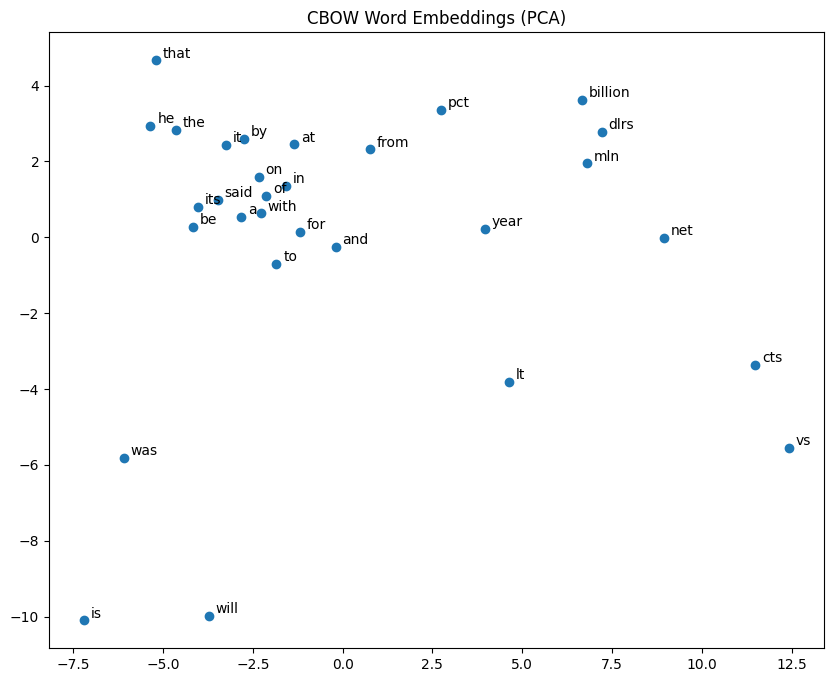

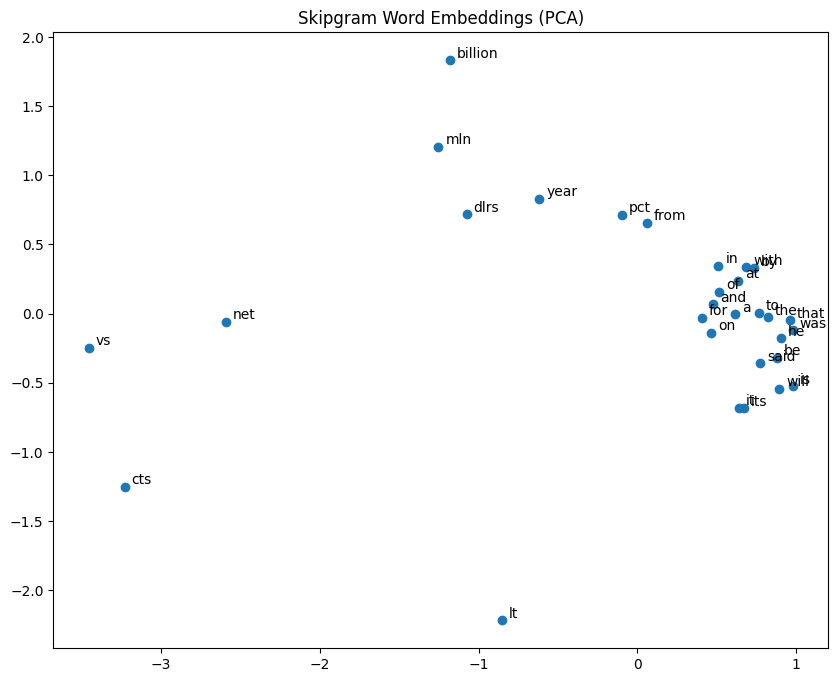

In [ ]:
!pip install --upgrade --quiet gensim==4.3.3 matplotlib scikit-learn nltk
!pip install --upgrade --force-reinstall numpy==1.26.4 gensim==4.3.3

import nltk
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

nltk.download('reuters')
nltk.download('punkt')
nltk.download('punkt_tab')
documents = reuters.fileids()
corpus = [reuters.raw(doc_id) for doc_id in documents]

# Preprocess text
def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]
    return tokens

tokenized_corpus = [preprocess(doc) for doc in corpus]


#Training Word2Vec models:
cbow_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=5, sg=0, workers=4)
skipgram_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=5, sg=1, workers=4)



# Evaluating similarity
print("CBOW similarity (money vs bank):", cbow_model.wv.similarity("money", "bank"))
print("Skipgram similarity (money vs bank):", skipgram_model.wv.similarity("money", "bank"))

#Selecting most frequent 30 words
all_tokens = [word for doc in tokenized_corpus for word in doc]
freq_words = [w for w, _ in Counter(all_tokens).most_common(30)]
print("Most frequent 30 words:", freq_words)


#Safe analogy function using frequent words
def analogy_safe(model, w1, w2, w3):
    for w in [w1, w2, w3]:
        if w not in model.wv:
            return f"'{w}' not in vocabulary"
    return model.wv.most_similar(positive=[w1, w3], negative=[w2], topn=1)



# Picking some words from top frequent words for analogy
if len(freq_words) >= 3:
    w1, w2, w3 = freq_words[0], freq_words[1], freq_words[2]
    print(f"CBOW analogy ({w1} - {w2} + {w3}):", analogy_safe(cbow_model, w1, w2, w3))
    print(f"Skipgram analogy ({w1} - {w2} + {w3}):", analogy_safe(skipgram_model, w1, w2, w3))


#PCA and plotting function
def plot_embeddings(model, words, title):
    valid_words = [w for w in words if w in model.wv]
    X = np.array([model.wv[w] for w in valid_words])
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)

    plt.figure(figsize=(10, 8))
    plt.scatter(result[:, 0], result[:, 1])

    for i, word in enumerate(valid_words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]), xytext=(5, 2), textcoords='offset points')

    plt.title(title)
    plt.show()


#Plot CBOW and Skipgram embeddings
plot_embeddings(cbow_model, freq_words, "CBOW Word Embeddings (PCA)")
plot_embeddings(skipgram_model, freq_words, "Skipgram Word Embeddings (PCA)")


Comparison of CBOW vs Skip-gram on Reuters corpus:

CBOW: Faster, predicts a word from context, works well for frequent words, clusters frequent words closely.

Skip-gram: Slower, predicts context from a word, better for rare words, captures semantic relationships more clearly, clusters show meaningful word relationships.

Observation: CBOW gives general patterns; Skip-gram gives richer semantic structure and better analogy results.